# EEG Microstates

In continually recorded human EEG, it is evident that the spatial distribution of electric potential across the cortex changes discontinuously over time. However, for brief time periods (60 - 120ms), quasi-stable states (**microstates**), characterized by unique configurations of potential distributions, have been observed. 

In [118]:
# Load the NeuroKit package and other useful packages
import neurokit2 as nk
import matplotlib.pyplot as plt
import mne


In [69]:
# This "decorative" cell should be hidden from the docs once this is implemented:
# https://github.com/microsoft/vscode-jupyter/issues/1182 
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

## Download the Dataset

First, let's download the raw eeg data (sampled at 150.15Hz) using `nk.mne_data()`.

In [175]:
raw = nk.mne_data("filt-0-40_raw")

# You can crop the data for faster processing. 
# Note: `smin` and `smax` refer to the minimum and maximum sample to include

raw_cropped = nk.mne_crop(raw, smin=500, smax=5500)


## Preprocess the Raw Signal

EEG recordings measure the difference in electric potential between each electrode and a reference electrode. This means that the ideal reference electrode is one which records **all** the interfering noise from the environment but doesn't pick up any fluctuating signals related to brain activity. 

The idea behind re-referencing is to express the voltage at the EEG scalp channels with respect to another, new reference. This "virtual reference" can be any recorded channel, or the average of all the channels.

Below, we will apply a band-pass filter and re-reference the signals to remove power line noise, slow drifts and other large artifacts from the raw input.

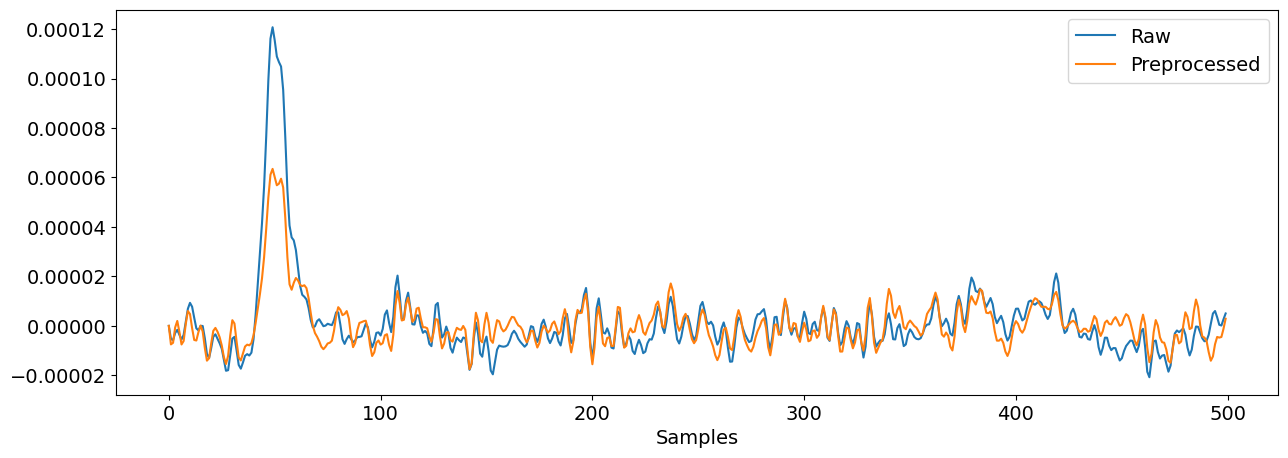

In [177]:
# Apply band-pass filter (1-30Hz) and re-reference the raw signal
eeg = raw_cropped.filter(1, 30, verbose = False)
eeg = nk.eeg_rereference(eeg, 'average')

# Compare the raw and preprocessed signal
signal_raw = raw_cropped.get_data()
signal_cleaned = eeg.get_data()

nk.signal_plot([signal_raw[0, 0:500], signal_cleaned[0, 0:500]], labels =["Raw", "Preprocessed"])


## Extract Microstates

Now that you have finished all the preprocessing, you're ready to identify and extract microstates from your 'cleaned' signal!

## Global Field Power (GFP) Peaks

Global Field Power (GFP) is a reference-independent measure of potential field strength. It is thought to quantify the integrated electrical activity of the brain and is mathematically defined as the standard deviation of all electrodes at a given time. 

GFP time series periodically achieves peaks, where the EEG topographies are most clearly defined (i.e., signal-to-noise ratio is maximized at GFP peaks). As such, GFP peak samples are often used to extract microstates.

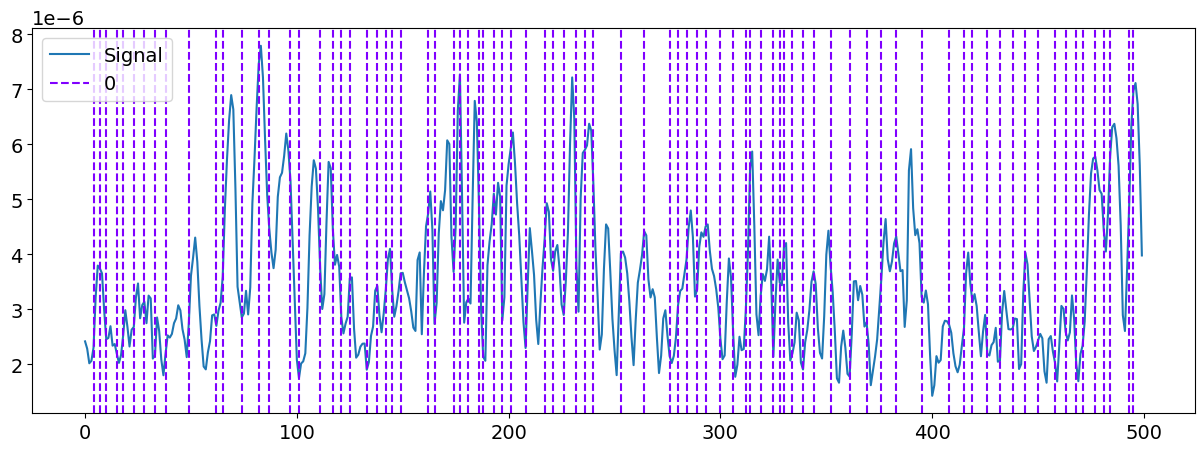

In [196]:
gfp = nk.eeg_gfp(eeg)

peaks = nk.microstates_peaks(eeg, distance_between=0.01)

nk.events_plot([peaks[peaks < 500]], gfp[300:800])

## Extract Microstates

Several different clustering algorithms can be used to segment your EEG recordings into microstates. These algorithms mainly differ in how they define cluster membership and the cost functionals to be optimized ([Xu & Tian, 2015](10.1007/s40745-015-0040-1)). The method to use hence depends on your data and the underlying assumptions of the methods (e.g., some methods ignore polarity). There is no one true method that gives the best results but you can refer to [Poulsen et al., 2018](https://www.researchgate.net/publication/331367421_Microstate_EEGlab_toolbox_An_introductory_guide#pf6) if you would like a more detailed review of the different clustering methods!

In the example below, we will compare the two most commonly applied clustering algorithms - the *K-means* and *modified K-means*. Other methods that can be applied using `nk.mircostates_segment` include `kmedoids, pca, ica, aahc`. 

It should be noted the modified K-Means is different from the conventional method in 2 major ways:
1. Models the strength of the microstate at each time point. 
    - This implies that only **one** microstate is taken to be active at a given time point. 
2. Potential distribution maps are regarded as **polarity-invariant** 
    - samples with potential distribution maps that are proportional but have opposite polarity will be assigned the **same** microstate class. 

 Using conventional Kmeans,  GEV = 0.4797488487694372
 Using modified Kmeans,  GEV = 0.6579651762423846


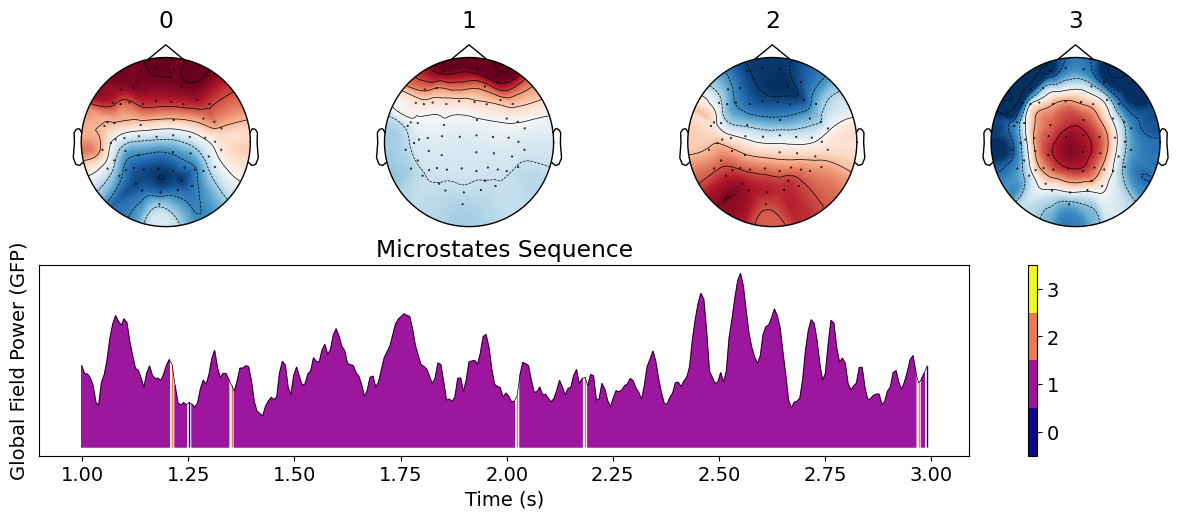

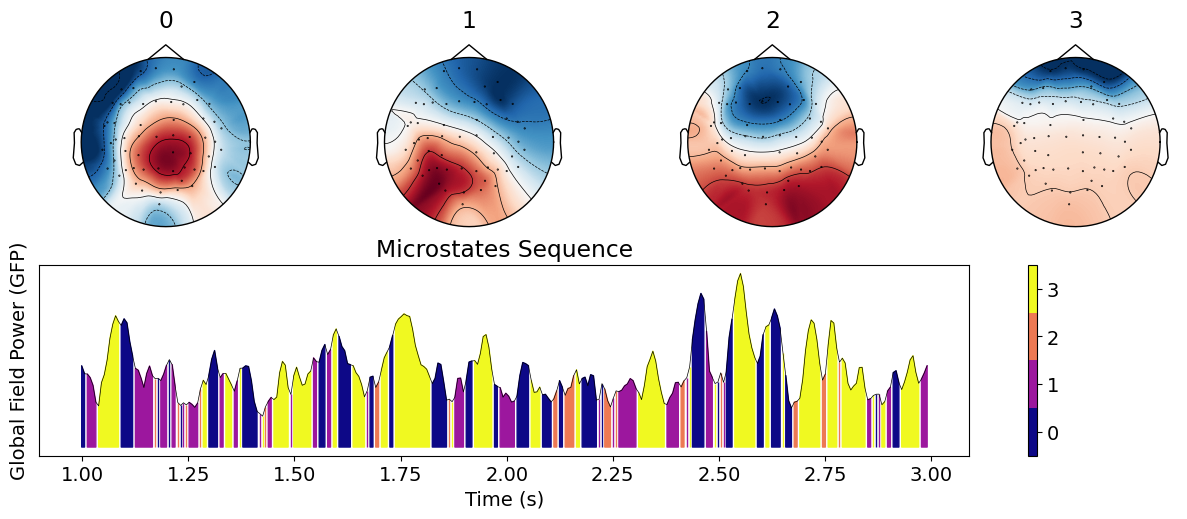

In [194]:
# Extract microstates
# Note: nk.microstates_segment defaults to using GFP peaks to identify microstates (`train = "gfp"`)
microstates_kmeans = nk.microstates_segment(eeg, method="kmeans")
microstates_kmod = nk.microstates_segment(eeg, method="kmod")  

# Global Explained Variance
gev_kmeans = microstates_kmeans['GEV']
gev_kmod = microstates_kmod['GEV']
print( f' Using conventional Kmeans,  GEV = {gev_kmeans}')
print( f' Using modified Kmeans,  GEV = {gev_kmod}')

# Visualize the extracted microstates
nk.microstates_plot(microstates_kmeans, epoch = (150, 450))
nk.microstates_plot(microstates_kmod, epoch = (150, 450))

As observed from the plots above, the microstates extracted look largely similar besides some differences in polarity between classes 0 and 1 (computed using kmeans, i.e., top plot) with classes 1 and 3 (computed using modified kmeans, i.e., bottom plot) respectively. However, using different methods can result in the same samples being assigned different classes of microstates.

## Find the Ideal Number of Clusters

Often, the clustering algorithms require the number of clusters to extract to first be defined (using the `n_microstates` (which defaults to 4) parameter in `nk.microstates_segment`). A variety of indices of fit has hence been used to estimate the ideal number to extract. This includes:
- Global Explained Variance (GEV): measures how similar each EEG sample is to its assigned microstate class; the **higher (closer to 1)**, the better the segmentation
- Krzanowski-Lai Criterion (KL): measures quality of microstate segmentation based on the dispersion measure (average distance between samples in the same microstate class); the **larger the KL value**, the better the segmentation


*Note that KL is not a polarity invariant measure and thus might not be a suitable measure of fit for polarity-invariant methods such as modified K-means and (T)AAHC*

In [10]:
nk.microstates_findnumber(eeg, max=10)

0 2
1 3
2 4
3 5
4 6
5 7
6 8
7 9
8 10
9 11
10 12


,Score_GEV,KL_Criterion
0,0.590910,NaN
1,0.641630,1.909119
2,0.670138,0.732272
3,0.688978,8.431304
4,0.703076,0.199963
5,0.713073,1.706508
6,0.720282,64.639834
7,0.726010,0.019998
8,0.730686,95.056974
9,0.735260,0.010864


Using GEV as a measure of fit, it seems 4 is the ideal number of microstates to extract, consistent with the default number used in the above example!